BLOCO 1 — Carregamento e tratamento dos dados

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, mutual_info_classif

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)

from google.colab import files  # para download de arquivos

# =========================
# Configurações gerais
# =========================
DATA_PATH = "dados_tratados.csv"  # ajuste se necessário
RANDOM_STATE = 42
TEST_SIZE = 0.20

# =========================
# 1) Carregar & TRATAMENTO
# =========================
df = pd.read_csv(DATA_PATH)

# Remover ID se existir
if "ID_Cliente" in df.columns:
    df = df.drop(columns=["ID_Cliente"])

# Remover linhas sem target
df = df.dropna(subset=["Cancelou"])

# Binarizar target (Yes/No -> 1/0)
if df["Cancelou"].dtype == "object":
    df["Cancelou"] = (
        df["Cancelou"].astype(str).str.strip().str.lower().map({"yes": 1, "no": 0})
    )
df["Cancelou"] = (df["Cancelou"] > 0).astype(int)

y = df["Cancelou"].astype(int)
X = df.drop(columns=["Cancelou"])

# Detectar tipos
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print(f"[INFO] Linhas: {len(df)} | Numéricas: {len(num_cols)} | Categóricas: {len(cat_cols)}")


[INFO] Linhas: 7043 | Numéricas: 4 | Categóricas: 15


BLOCO 2 — Pré-processamento (encoding + normalização)

In [64]:
# ===========================================
# 2) ENCODING + 3) NORMALIZAÇÃO
# ===========================================
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),  # matriz densa
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop"
)

# Split treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

preprocessor.fit(X_train)
X_train_proc = preprocessor.transform(X_train)
X_test_proc = preprocessor.transform(X_test)

def get_feature_names(column_transformer, num_cols, cat_cols):
    """Extrai nomes das features após ColumnTransformer (numéricas + OneHot)."""
    out = []
    out.extend(num_cols)
    ohe = column_transformer.named_transformers_["cat"].named_steps["onehot"]
    ohe_names = ohe.get_feature_names_out(cat_cols).tolist()
    out.extend(ohe_names)
    return out

feature_names = get_feature_names(preprocessor, num_cols, cat_cols)


BLOCO 3 — Correlação e gráfico top 15

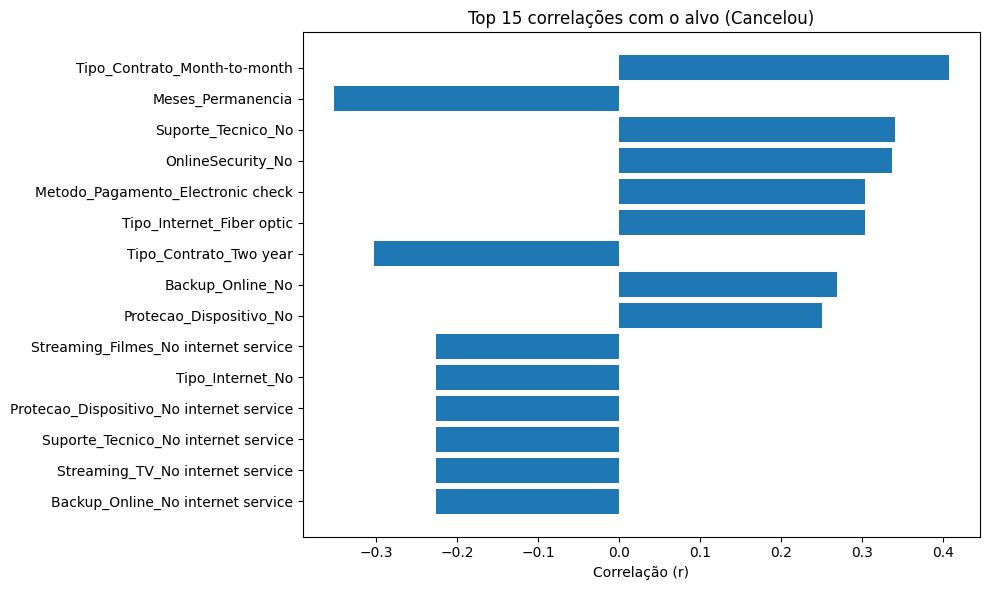

In [65]:
# ====================================
# 4) ANÁLISE DE CORRELAÇÃO
# ====================================
X_train_dense = np.asarray(X_train_proc)
y_centered = (y_train - y_train.mean()).values.reshape(-1, 1)
X_centered = X_train_dense - X_train_dense.mean(axis=0)

num_ = (y_centered.T @ X_centered).ravel()
den_ = np.sqrt(((y_train.shape[0]-1) * y_train.var()) * ((X_centered**2).sum(axis=0)))
den_ = np.where(den_ == 0, np.nan, den_)
corr_values = num_ / den_

corr_df = (
    pd.DataFrame({"feature": feature_names, "corr_with_target": corr_values})
    .dropna()
    .sort_values(by="corr_with_target", key=np.abs, ascending=False)
)

# Exibir top 15 correlações
top_corr = corr_df.head(15)
plt.figure(figsize=(10, 6))
plt.barh(top_corr["feature"][::-1], top_corr["corr_with_target"][::-1])
plt.title("Top 15 correlações com o alvo (Cancelou)")
plt.xlabel("Correlação (r)")
plt.tight_layout()
plt.show()

BLOCO 4 — Seleção de variáveis (Mutual Information)

In [66]:
# ===========================================
# 5) SELEÇÃO DE VARIÁVEIS
# ===========================================
k = min(25, X_train_dense.shape[1])
selector = SelectKBest(score_func=mutual_info_classif, k=k)
selector.fit(X_train_proc, y_train)

mi_scores = selector.scores_
selected_mask = selector.get_support()
selected_features = [f for f, keep in zip(feature_names, selected_mask) if keep]

#mi_df = pd.DataFrame({"feature": feature_names, "mutual_info": mi_scores})\
#         .sort_values(by="mutual_info", ascending=False)
#mi_df.to_csv("mutual_information_todas.csv", index=False)
#files.download("mutual_information_todas.csv")

#with open("features_selecionadas.txt", "w", encoding="utf-8") as f:
#    for feat in selected_features:
#        f.write(feat + "\n")
#files.download("features_selecionadas.txt")

print(f"[INFO] Seleção por MI concluída. K={k} features salvas.")


[INFO] Seleção por MI concluída. K=25 features salvas.


BLOCO 5 — Treinamento e avaliação dos modelos + ROC

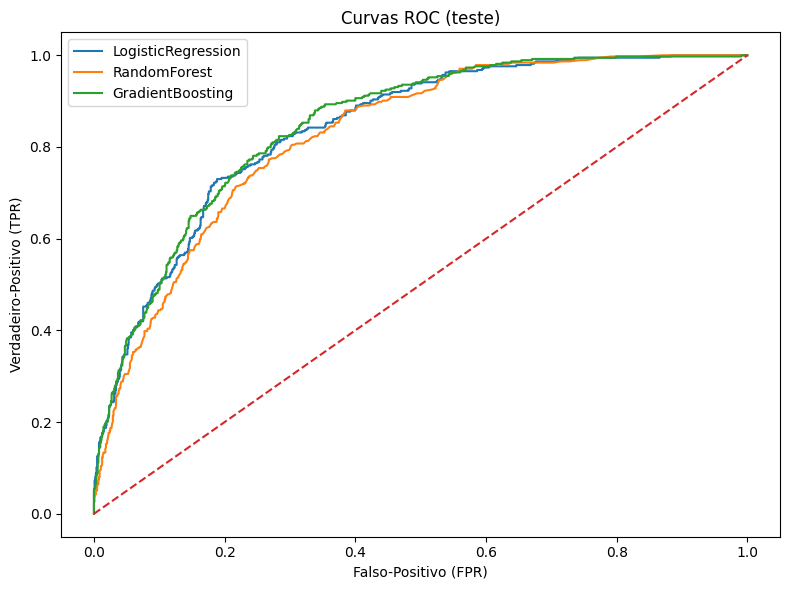

In [67]:
# ================================================
# 6) TREINAR MODELOS + AVALIAR
# ================================================
def build_pipeline(model):
    return Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("selector", selector),
        ("model", model)
    ])

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, solver="liblinear", random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(n_estimators=400, random_state=RANDOM_STATE),
    "GradientBoosting": GradientBoostingClassifier(random_state=RANDOM_STATE),
}

results = []
roc_points = {}

for name, clf in models.items():
    pipe = build_pipeline(clf)
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    y_proba = (
        pipe.predict_proba(X_test)[:, 1]
        if hasattr(pipe, "predict_proba")
        else pipe.decision_function(X_test)
    )

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_proba)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    results.append({
        "modelo": name,
        "accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": auc,
        "tn": tn, "fp": fp, "fn": fn, "tp": tp
    })

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_points[name] = (fpr, tpr)

#      # salvar relatório
 #     report = classification_report(y_test, y_pred, digits=4)
  #    with open(f"classification_report_{name}.txt", "w") as f:
   #       f.write(report)
    #  files.download(f"classification_report_{name}.txt")

#  metrics_df = pd.DataFrame(results).sort_values(by="roc_auc", ascending=False).reset_index(drop=True)
 # metrics_df.to_csv("metricas_modelos.csv", index=False)
  #files.download("metricas_modelos.csv")
#  print("\n[Métricas no teste]")
 # print(metrics_df)

# Curvas ROC
plt.figure(figsize=(8, 6))
for name, (fpr, tpr) in roc_points.items():
    plt.plot(fpr, tpr, label=name)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("Curvas ROC (teste)")
plt.xlabel("Falso-Positivo (FPR)")
plt.ylabel("Verdadeiro-Positivo (TPR)")
plt.legend()
plt.tight_layout()
plt.show()


BLOCO 6 — Interpretação das importâncias das features

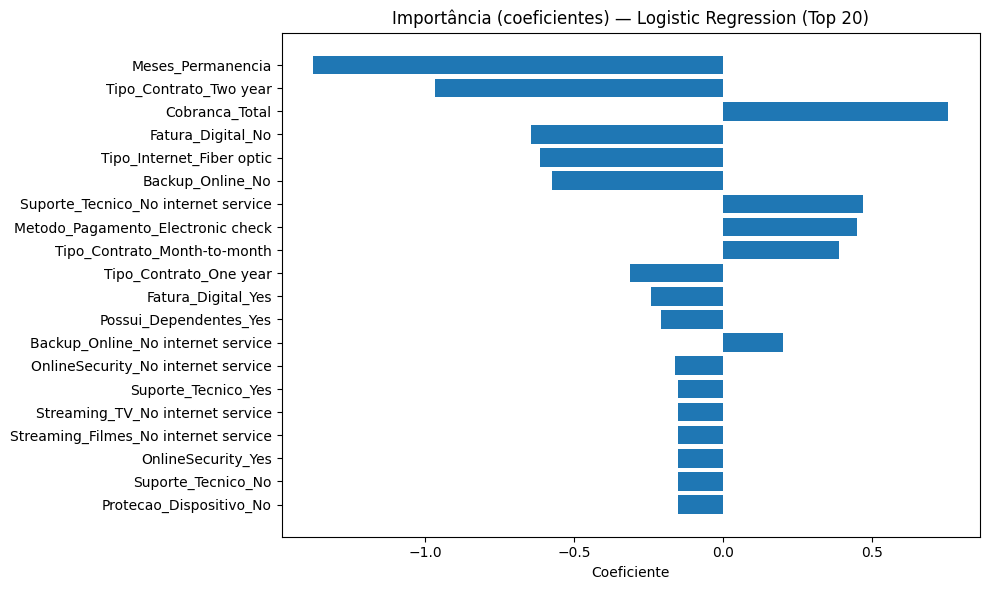

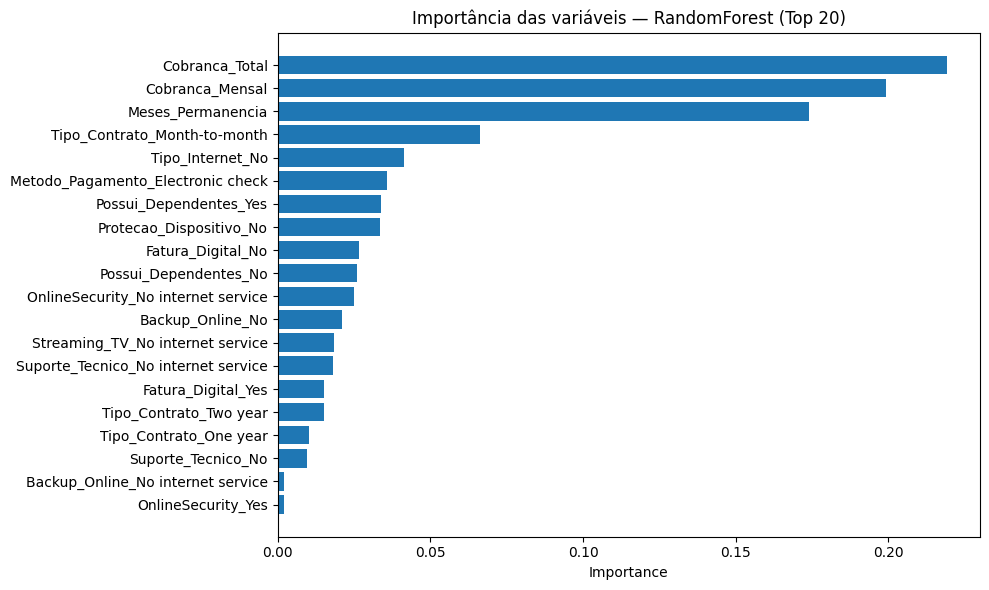

In [68]:
# ===========================================
# 7) INTERPRETAÇÃO — Importância das variáveis
# ===========================================
final_pipes = {name: build_pipeline(clf).fit(X_train, y_train) for name, clf in models.items()}
selected_feature_names = selected_features

# Logistic Regression
logreg = final_pipes["LogisticRegression"].named_steps["model"]
log_coef = logreg.coef_.ravel()
log_imp_df = pd.DataFrame({
    "feature": selected_feature_names,
    "coef": log_coef,
    "abs_coef": np.abs(log_coef)
}).sort_values("abs_coef", ascending=False)

#log_imp_df.to_csv("importancias_logistic.csv", index=False)
#files.download("importancias_logistic.csv")

plt.figure(figsize=(10, 6))
top20_log = log_imp_df.head(20)
plt.barh(top20_log["feature"][::-1], top20_log["coef"][::-1])
plt.title("Importância (coeficientes) — Logistic Regression (Top 20)")
plt.xlabel("Coeficiente")
plt.tight_layout()
plt.show()

# RandomForest
rf = final_pipes["RandomForest"].named_steps["model"]
rf_importances = rf.feature_importances_
rf_imp_df = pd.DataFrame({
    "feature": selected_feature_names,
    "importance": rf_importances
}).sort_values("importance", ascending=False)

#rf_imp_df.to_csv("importancias_randomforest.csv", index=False)
#files.download("importancias_randomforest.csv")

plt.figure(figsize=(10, 6))
top20_rf = rf_imp_df.head(20)
plt.barh(top20_rf["feature"][::-1], top20_rf["importance"][::-1])
plt.title("Importância das variáveis — RandomForest (Top 20)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [69]:
# =========================
# 8) Conclusão estratégica
# =========================
print("\n[Conclusão estratégica — exemplo]")
print("- Contratos Month-to-month e menor tempo de permanência elevam o churn; contratos de 1–2 anos reduzem.")
print("- Serviços de segurança/suporte e combos reduzem risco; ausência deles aumenta.")
print("- Cobrança mensal alta e pagamento via 'electronic check' aparecem associados a maior churn.")
print("- Recomendações:")
print("    • Migrar clientes para contratos 12–24 meses com bônus.")
print("    • Bundles de segurança + suporte para retenção.")
print("    • Ofertas direcionadas para clientes com cobrança mensal alta.")
print("    • Atenção especial aos primeiros meses do ciclo de contrato.")



[Conclusão estratégica — exemplo]
- Contratos Month-to-month e menor tempo de permanência elevam o churn; contratos de 1–2 anos reduzem.
- Serviços de segurança/suporte e combos reduzem risco; ausência deles aumenta.
- Cobrança mensal alta e pagamento via 'electronic check' aparecem associados a maior churn.
- Recomendações:
    • Migrar clientes para contratos 12–24 meses com bônus.
    • Bundles de segurança + suporte para retenção.
    • Ofertas direcionadas para clientes com cobrança mensal alta.
    • Atenção especial aos primeiros meses do ciclo de contrato.
